# Overview #

In this notebook, a Mask R-CNN model will be built and trained to detect instances of pneumonia in patients' lung x-ray scans. The model will be trained on the dataset and inferences made on the test set. Finally, the model's prediction will be evaluated to determine it's level of accuracy.

Detailed analysis of the dataset is provided in the [pneumonia_detection_analysis.ipynb](pneumonia_detection_analysis.ipynb) notebook.

# Import classes & libraries #

In [23]:
import os 
import sys

import random
import math
import numpy as np
import cv2
import matplotlib.pyplot as plt
import json
import pydicom
from imgaug import augmenters as iaa
from tqdm import tqdm
import pandas as pd 
import glob
import warnings
warnings.filterwarnings("ignore")

import utils.utils as ut

%matplotlib inline

DATASET_DIR = 'dataset'
TRAIN_IMAGES = DATASET_DIR + os.sep + 'train_images'
TEST_IMAGES = DATASET_DIR + os.sep + 'test_images'
MODEL_DIR = 'logs'
MODEL = os.path.join(MODEL_DIR, "mask_rcnn_pneumonia_detection.h5")
ANALYSIS_DIR = 'analysis'

# Make logs directory if it doesn't exist.
if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR)

# Download Dataset and Mask R-CNN library #

The dataset can be downloaded from Kaggle. Run the code below to download it.

***Note: You must accept the user agreement on the competition website! Then follow [instructions to obtain your Kaggle Credentials](https://github.com/Kaggle/kaggle-api#api-credentials).***

In [2]:
ut.download_dataset(DATASET_DIR, '<your_kaggle_username>', '<your_kaggle_api_key>')
ut.download_mask_rcnn()

Creating dataset directory.
Unzipping dataset files...
Removing zip files...
Dataset downloaded successfully.

Cloning Mask R-CNN...
Finishing cloning R-CNN


# Import Mask R-CNN and Pnuemonia Detection Configurations #

In [24]:
import sys
sys.path.append('Mask_RCNN')
sys.path.append('pneumonia_detection')

import mrcnn.model as mrcnn_model
from mrcnn import visualize
from mrcnn.model import log

from pneumonia_detection_config import PneumoniaDetectionConfig as PDConfig
from pneumonia_detection_dataset import PneumoniaDetectionDataset as PDDataset
from pneumonia_detection_config import PneumoniaDetectionInferenceConfig as PDInferenceConfig

config = PDConfig()
config.display()

ORIG_DICOM_SIZE = 1024


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        400
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  1024
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INST

# Load training dataset and split into `train_data` and `val_data` #

The dataset for training is loaded from the training directory and using the training labels, parsed to produce a dictionary of patient and their pneumonia status information.

In [25]:
dataframe = pd.read_csv(os.path.join(DATASET_DIR, 'train_labels.csv'))
all_dataset = ut.parse_data(TRAIN_IMAGES, dataframe)
all_dataset = list(all_dataset.values())  # We only need the dict values

# Split dataset into train_data and val_data in the ratio 9:1
random.seed(42)
random.shuffle(all_dataset)

val_split = .1
split_idx = int((1 - val_split) * len(all_dataset))

train_data = all_dataset[:split_idx]
val_data = all_dataset[split_idx:]

print('Training dataset size: {} \nValidation dataset size: {}'.format(len(train_data), len(val_data)))

Training dataset size: 23115 
Validation dataset size: 2569


#### For experimental training purposes and validation purposes, uncomment and run the cell block below to get a subset of training and validation data ####

To speed up training, 1% of training dataset and 3% of validation dataset will be used.

In [4]:
# experimental = True
# train_data_split = .01
# val_data_split = .03

# # We only want annotated images for training and validation
# td = []
# vd = []
# for d in train_data:
#     if len(d['boxes']) > 0:
#         td.append(d)
        
# for d in val_data:
#     if len(d['boxes']) > 0:
#         vd.append(d)

# train_data = td[:int(train_data_split * len(td))]
# val_data = vd[:int(val_data_split * len(vd))]

# print('Training dataset size (experiemental): {} \nValidation dataset size (experiemental): {}'
#       .format(len(train_data), len(val_data)))

Training dataset size (experiemental): 50 
Validation dataset size (experiemental): 18


# Create and prepare training and validation datasets #

In [26]:
train_dataset = PDDataset(train_data, ORIG_DICOM_SIZE, ORIG_DICOM_SIZE)
train_dataset.prepare()

val_dataset = PDDataset(val_data, ORIG_DICOM_SIZE, ORIG_DICOM_SIZE)
val_dataset.prepare()

# We only need to train on the annotated dataset since those have pneumonia
print('Total annotated training dataset size: {} \nTotal annotated validation dataset size: {}'
      .format(len(train_dataset.image_ids), len(val_dataset.image_ids)))

Total annotated training dataset size: 5061 
Total annotated validation dataset size: 598


### Display a random  dicom image to verify that images were loaded successfully ###

Load and display a random dicom image. If the image has pneumonia, bounding boxes will be draw around them and their mask representation shown.

*Run this cell several times to see different results.*

Image size: (1024, 1024, 3)
Image location: dataset/train_images/80314888-a5ec-4ba1-8cf4-ad9c67fac5ba.dcm
Class IDs: [1 0 0]


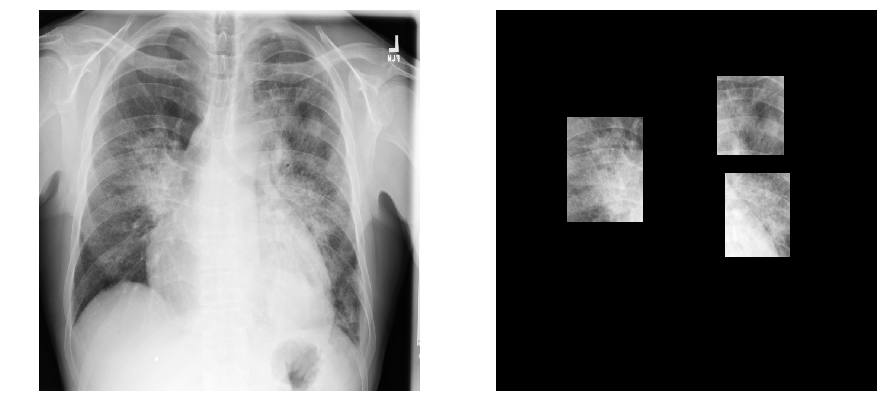

In [10]:
image_id = random.choice(train_dataset.image_ids)
image_loc = train_dataset.image_reference(image_id)
image = train_dataset.load_image(image_id)
mask, class_ids = train_dataset.load_mask(image_id)

print('Image size: {}'.format(image.shape))

plt.figure(figsize=(15, 15))

plt.subplot(121)
plt.imshow(image[:, :, 0], cmap='gray')
plt.axis('off')

plt.subplot(122)
masked = np.zeros(image.shape[:2])
for i in range(mask.shape[2]):
    masked += image[:, :, 0] * mask[:, :, i]
plt.imshow(masked, cmap='gray')
plt.axis('off')

print('Image location: {}'.format(image_loc))
print('Class IDs: {}'.format(class_ids))

# Prepare the model and augment images for training #

In [5]:
from mrcnn import utils

model = mrcnn_model.MaskRCNN(mode='training', config=config, model_dir=MODEL_DIR)

def load_training_weights(model, config, init_training=False):
    """
    Load training weights by determining if there is already weights for 
    pneumonia a detection model. If there's none, use coco weights.
    If initial training is set to false, then continue training by loading
    last trained epoch weights
    
    @params: model -> pneumonia detection model
    @params: config -> pneumonia detection configuration
    @params: init_training -> boolean indicating if training is conitnuing
                or starting afresh
    @return: training weights path
    """
            
    if os.path.exists(MODEL) and init_training:
        # If model weights exist and training is intended to start 
        # from epoch 1
        print('Loading pneumonia detection model.')
        weights_path = MODEL
        pre_trained = False
        print('Pneumonia detection trained model found in {}'.format(weights_path))
    elif not os.path.exists(MODEL) and init_training:
        # Download and use COCO dataset weights
        # if model path does not exist and training is intended to start
        # from epoch 1
        weights_path, pre_trained = load_coco_weights(model)
    elif not init_training:
        # If continuing training.
        # Try loading last trained model and continue training
        # else load coco dataset model and start training
        # from epoch 1 -> fall back
        try:
            print('Loading last trained weights.')
            weights_path = ut.load_last_model(model.model_dir, config)
            model.load_weights(weights_path, by_name=True)
            pre_trained = True
            print('Pneumonia detection trained model found in {}.'.format(weights_path))
        except:
            weights_path, pre_trained = load_coco_weights(model)
            
    return weights_path, pre_trained
        
def load_coco_weights(model):
    print('Weights not found. Attempting to download pretrained COCO weights.')
    weights_path = os.path.join(MODEL_DIR, 'mask_rcnn_coco.h5')
    if not os.path.exists(weights_path):
        utils.download_trained_weights(weights_path)

    # Exclude the last layers because they require a matching
    # number of classes
    print('Loading COCO weights.')
    model.load_weights(weights_path, by_name=True, exclude=[
        "mrcnn_class_logits", "mrcnn_bbox_fc",
        "mrcnn_bbox", "mrcnn_mask"])
    pre_trained = False
    print('COCO weights loaded.')
    
    return weights_path, pre_trained

In [7]:
# If starting new training, uncomment this line
# weights_path, pre_trained = load_training_weights(model, config, True)

# If continuing previous training, uncomment this line
weights_path, pre_trained = load_training_weights(model, config, False)

Loading last trained weights.
No weight files in logs/pneumonia_detection20180926T1241
Re-starting from epoch 100
Pneumonia detection trained model found in logs/pneumonia_detection20180917T1555/mask_rcnn_pneumonia_detection_0100.h5.


In [6]:
# Image augmentation
# http://imgaug.readthedocs.io/en/latest/source/augmenters.html
augmentation = iaa.SomeOf((0, 2), [
    iaa.Affine(
        scale={"x": (1.0, 2.0), "y": (1.0, 2.0)},
        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
        rotate=(-25, 25),
        shear=(-8, 8)
    ),
    iaa.Fliplr(0.5),
    iaa.Flipud(0.5),
    iaa.Multiply((0.8, 1.5))
])

# Train the model #

The model will train on head layers since it's starting with the COCO trained weights. Subsequent trained weights will be pneumonia weights.

In [8]:
from keras.callbacks import CSVLogger

# Log loss functions
if pre_trained:
    logger = CSVLogger(os.path.join(MODEL_DIR, 'training_log.csv'), append=True)
else:
    logger = CSVLogger(os.path.join(MODEL_DIR, 'training_log.csv'), append=False)

epochs = 100

# Train using head layers if initial weight is COCO dataset weights
if os.path.samefile(weights_path, os.path.join(MODEL_DIR, 'mask_rcnn_coco.h5')):
    model.train(train_dataset, val_dataset, learning_rate=config.LEARNING_RATE, 
                epochs=epochs, layers='heads', augmentation=augmentation, custom_callbacks=[logger])
else:
    model.train(train_dataset, val_dataset, learning_rate=config.LEARNING_RATE, 
                epochs=epochs, layers='all', augmentation=augmentation, custom_callbacks=[logger])


Starting at epoch 100. LR=0.001

Checkpoint Path: logs/pneumonia_detection20180917T1555/mask_rcnn_pneumonia_detection_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a

### Save trained weights ###

In [9]:
model.keras_model.save_weights(MODEL)

# Examing loss functions #

In [6]:
import pandas as pd

training_df = pd.read_csv(os.path.join(MODEL_DIR, 'training_log.csv'))
training_df.head()

,epoch,loss,mrcnn_bbox_loss,mrcnn_class_loss,mrcnn_mask_loss,rpn_bbox_loss,rpn_class_loss,val_loss,val_mrcnn_bbox_loss,val_mrcnn_class_loss,val_mrcnn_mask_loss,val_rpn_bbox_loss,val_rpn_class_loss
0,0,5.856401,0.857265,0.146257,0.632748,4.059540,0.160569,4.283858,0.699804,0.069440,0.665396,2.822006,0.027189
1,1,4.968672,0.647197,0.153490,0.660146,3.484893,0.022923,4.458389,0.616573,0.185188,0.660201,2.976123,0.020282
2,2,4.513868,0.631233,0.150969,0.642592,3.068055,0.020997,4.381443,0.568492,0.173845,0.649314,2.968730,0.021041
3,3,4.539211,0.606739,0.123764,0.636760,3.149280,0.022646,4.928952,0.634140,0.187587,0.659355,3.429397,0.018451
4,4,4.718569,0.610989,0.148562,0.636168,3.302307,0.020520,4.524620,0.582201,0.159315,0.641924,3.121499,0.019659


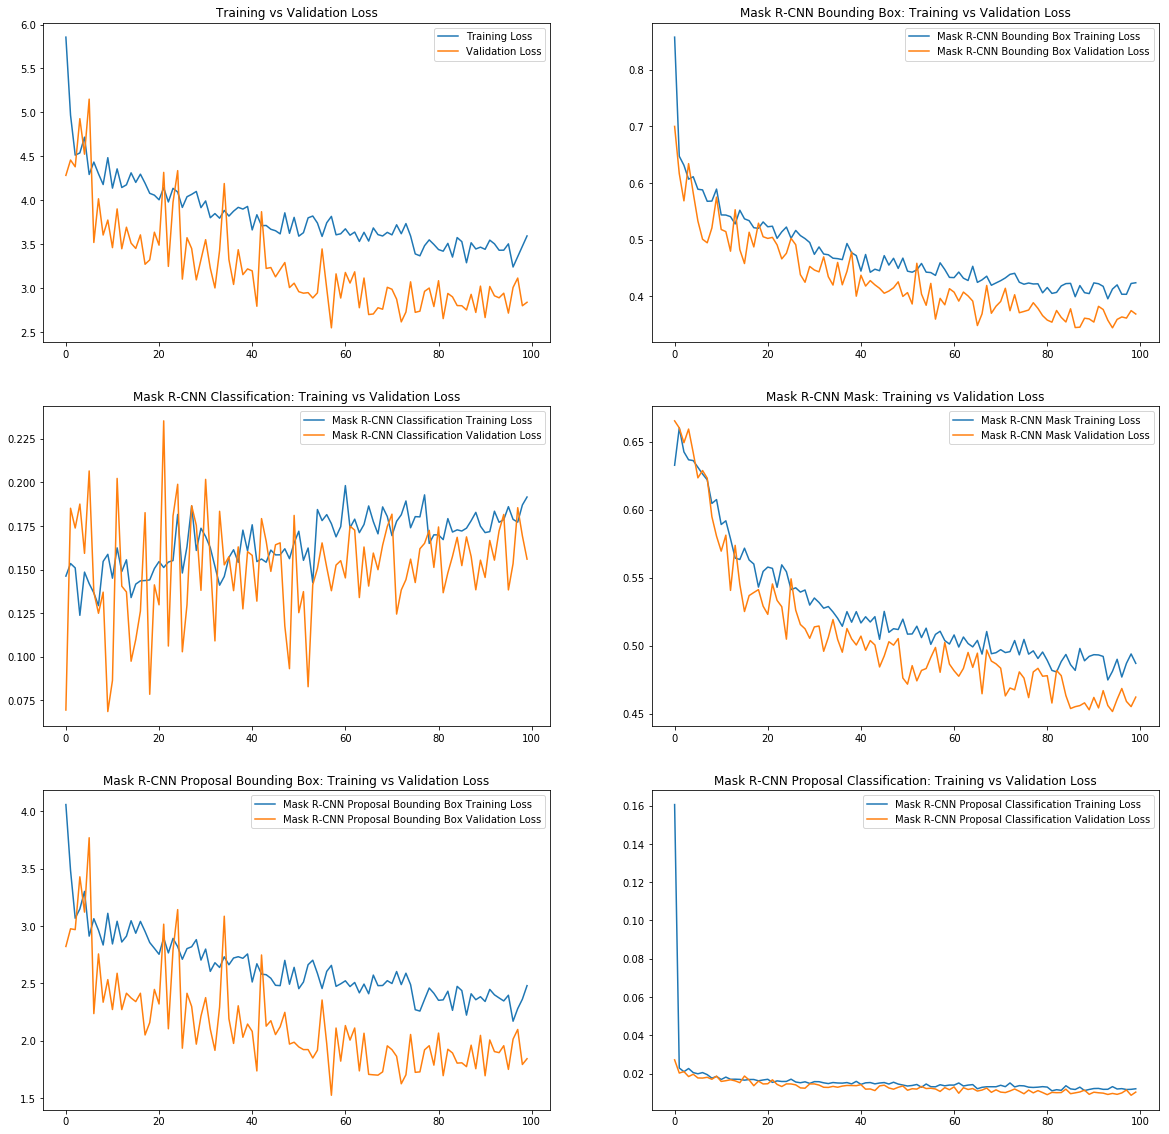

In [7]:
plt.figure(figsize=(20, 20))

plt.subplot(321)
plt.plot(training_df['epoch'], training_df['loss'], label='Training Loss')
plt.plot(training_df['epoch'], training_df['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.legend()

plt.subplot(322)
plt.plot(training_df['epoch'], training_df['mrcnn_bbox_loss'], label='Mask R-CNN Bounding Box Training Loss')
plt.plot(training_df['epoch'], training_df['val_mrcnn_bbox_loss'], label='Mask R-CNN Bounding Box Validation Loss')
plt.title('Mask R-CNN Bounding Box: Training vs Validation Loss')
plt.legend()

plt.subplot(323)
plt.plot(training_df['epoch'], training_df['mrcnn_class_loss'], label='Mask R-CNN Classification Training Loss')
plt.plot(training_df['epoch'], training_df['val_mrcnn_class_loss'], label='Mask R-CNN Classification Validation Loss')
plt.title('Mask R-CNN Classification: Training vs Validation Loss')
plt.legend()

plt.subplot(324)
plt.plot(training_df['epoch'], training_df['mrcnn_mask_loss'], label='Mask R-CNN Mask Training Loss')
plt.plot(training_df['epoch'], training_df['val_mrcnn_mask_loss'], label='Mask R-CNN Mask Validation Loss')
plt.title('Mask R-CNN Mask: Training vs Validation Loss')
plt.legend()

plt.subplot(325)
plt.plot(training_df['epoch'], training_df['rpn_bbox_loss'], label='Mask R-CNN Proposal Bounding Box Training Loss')
plt.plot(training_df['epoch'], training_df['val_rpn_bbox_loss'], label='Mask R-CNN Proposal Bounding Box Validation Loss')
plt.title('Mask R-CNN Proposal Bounding Box: Training vs Validation Loss')
plt.legend()

plt.subplot(326)
plt.plot(training_df['epoch'], training_df['rpn_class_loss'], label='Mask R-CNN Proposal Classification Training Loss')
plt.plot(training_df['epoch'], training_df['val_rpn_class_loss'], label='Mask R-CNN Proposal Classification Validation Loss')
plt.title('Mask R-CNN Proposal Classification: Training vs Validation Loss')
plt.legend()

plt.savefig(os.path.join(ANALYSIS_DIR, 'loss_fnc_plots.png'))
plt.show()

# Making inferences and detecting pneumonia #

Once training is completed, the model is used to detect pneumonia infections. First, we will attempt to detect pneumonia on the validation dataset before making final detections on the test dataset. Comparing ground truth cases against detections of the model on the validation will give an indication of how well the model is performing.

In [27]:
# Create an inference config object
inference_config = PDInferenceConfig()

# Recreate the model in inference mode
model = mrcnn_model.MaskRCNN(mode='inference', config=inference_config, model_dir=MODEL_DIR)

model_path = MODEL
assert model_path != None

try:
    model.load_weights(model_path, by_name=True)
    print('Models weights location: {}'.format(model_path))
except:
    print('No model weights found.')

Models weights location: logs\mask_rcnn_pneumonia_detection.h5


Let's compare ground truth validation set with predicted/detected results by the model.

*Run this cell several times to see different vizualizations.*


*** No instances to display *** 



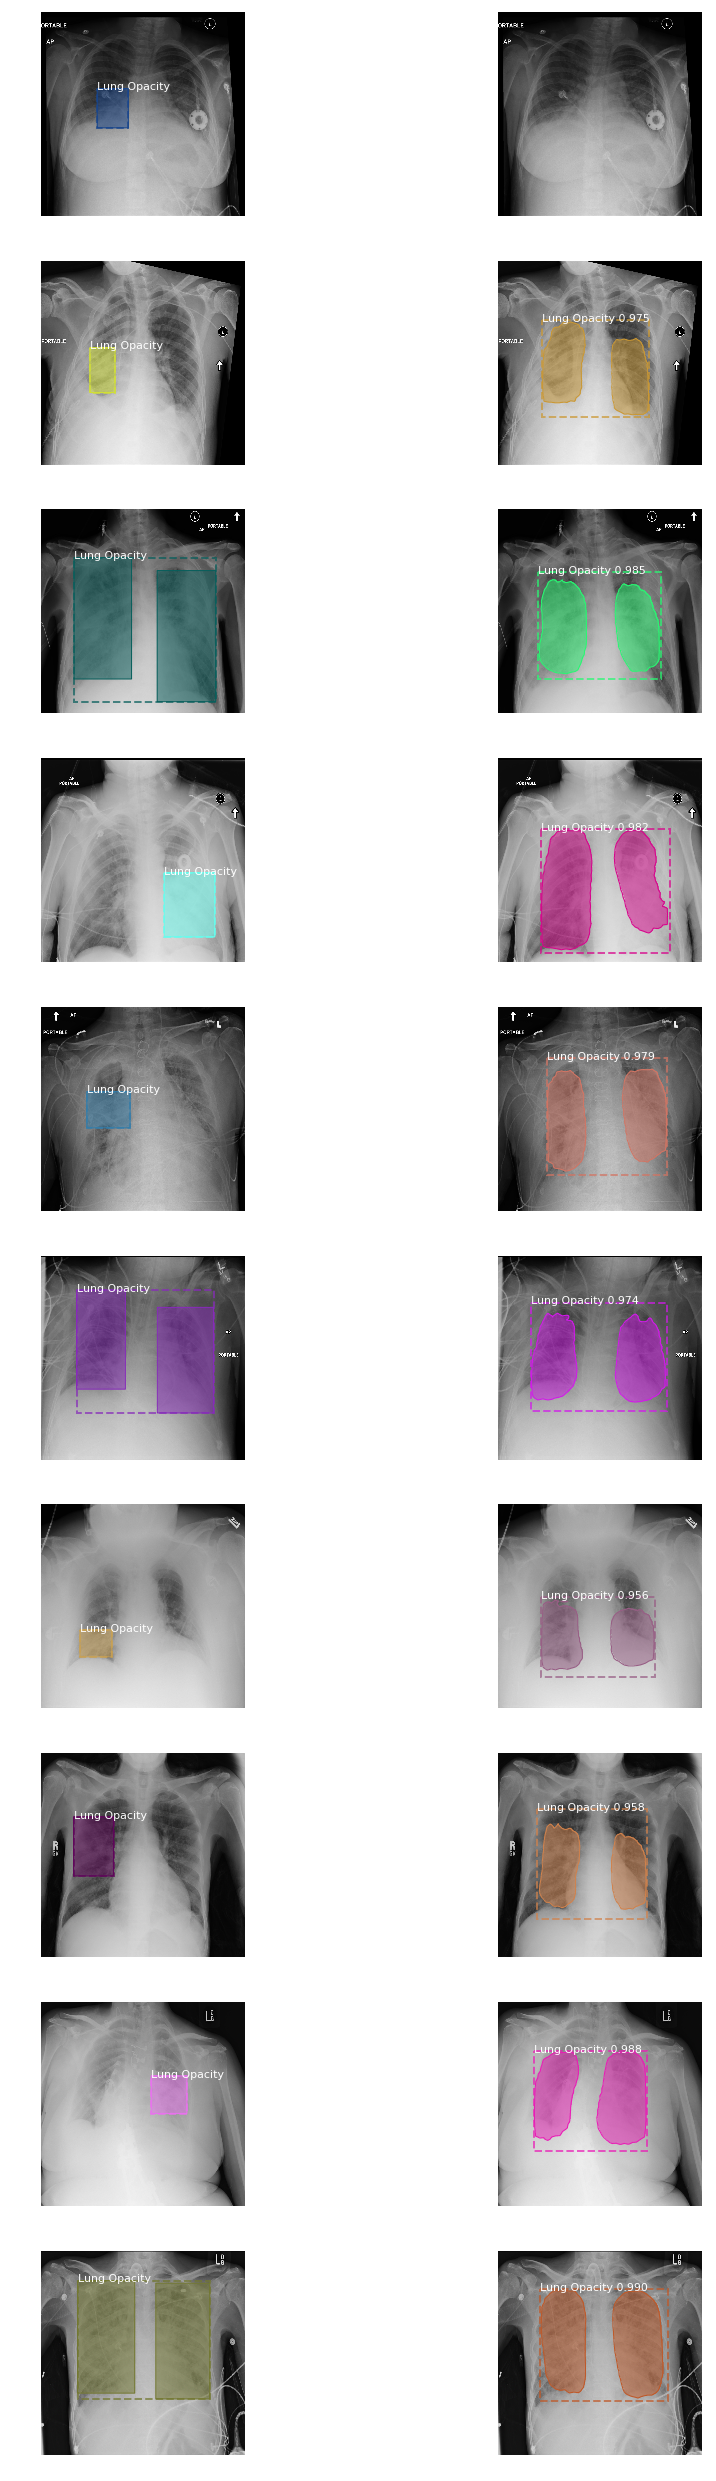

In [11]:
dataset_val = val_dataset  # We will work with a copy the validation dataset
fig = plt.figure(figsize=(15, 45))

for i in range(10):
    image_id = random.choice(dataset_val.image_ids)
    
    # Get original validation image files
    original_image, image_meta, gt_class_id, gt_bbox, gt_mask = \
        mrcnn_model.load_image_gt(val_dataset, inference_config, image_id, use_mini_mask=False)
    
    plt.subplot(10, 2, 2*i + 1)
    visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, dataset_val.class_names, 
                                colors=ut.splash_class_ids(gt_class_id), ax=fig.axes[-1])
    
    plt.subplot(10, 2, 2*i + 2)
    results = model.detect([original_image], verbose=0)
    result = results[0]
    visualize.display_instances(original_image, result['rois'], result['masks'], result['class_ids'], 
                                dataset_val.class_names, result['scores'], 
                                colors=ut.splash_class_ids(result['class_ids']), ax=fig.axes[-1])

# Evaluate model #

The [proposal.pdf](proposal.pdf) and [pneumonia_detection_report.pdf](pneumonia_detection_report.pdf) documents explain in details the evaluation metrics. The model will also be evaluated separately against an IoU of 0.5 in order to compare with the benchemark of Mask R-CNN on the COCO dataset.

In [12]:
iou_thresholds = list(np.arange(0.4, 0.8, 0.05))
APs = []
APs_5 = []

for image_id in val_dataset.image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        mrcnn_model.load_image_gt(val_dataset, inference_config,
                               image_id, use_mini_mask=False)
        
    molded_images = np.expand_dims(mrcnn_model.mold_image(image, inference_config), 0)
    
    # Run object detection
    result = model.detect([image], verbose=0)[0]
    
    try:
        # Compute APs for iou thresholds
        AP = utils.compute_ap_range(gt_bbox, gt_class_id, gt_mask, result["rois"], result["class_ids"], 
                                    result["scores"], result['masks'], iou_thresholds=iou_thresholds, verbose=0)
        APs.append(AP)
        
        AP_5, precisions_5, recalls_5, overlaps_5 =\
            utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                             result["rois"], result["class_ids"], result["scores"], result['masks'])
        APs_5.append(AP_5)
    except:
        pass
    
score = np.array(APs).mean()
score_5 = np.array(APs_5).mean()

print('Final evaluation score over IoU thresholds: {:.2f}%'.format(score * 100))
print('Final evaluation score @ IoU=0.5: {:.2f}%'.format(score_5 * 100))

Final evaluation score over IoU thresholds: 27.76%
Final evaluation score @ IoU=0.5: 43.11%


# Detect pneumonia instances #

The model will be used on the test images to detect pneumonia. A subset of the test images will be displayed and the results of the detection, written to CSV file.

In [38]:
def test_results(image_path=None):
    """Test model on test images and visualize"""
    
    # Get random test image
    image_file = image_path
    dicom = pydicom.read_file(image_file)
    image = dicom.pixel_array

    # Convert to RGB for consistency if in grayscale
    if len(image.shape) != 3 or image.shape[2] != 3:
        image = np.stack((image,) * 3, -1)

    patient_id = os.path.splitext(os.path.basename(image_file))[0]
    result = model.detect([image], verbose=1)[0]

    bbox = []
    rois = result['rois']  # returns y1, x1, y2, x2
    for i in range(len(rois)):
        coord = []
        coord.append(rois[i][1]) # x
        coord.append(rois[i][0]) # y
        coord.append(rois[i][3] - rois[i][1]) # width
        coord.append(rois[i][2] - rois[i][0]) # height
        bbox.append(coord)
    
    # Visualize detection with masks
    visualize.display_instances(image, result['rois'], result['masks'], result['class_ids'], 
                                val_dataset.class_names, result['scores'], 
                                colors=ut.splash_class_ids(result['class_ids']), figsize=(10, 10))

    # Draw detected image with bounding box.
    # image_data = { 'dicom': image_file, 'boxes': bbox }
    # ut.draw_dicom(image_data, figsize=(10, 10))

    print('Patient ID: {}\nConfidence Score: {}\nClass ID: {}'.format(patient_id, result['scores'], 
                                                                      result['class_ids']))

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.08847  max:    1.02591  float32
Patient ID: 1e57ff83-f0cb-4f2a-b8c5-f916ccd0e2c0
Confidence Score: [ 0.97246045]
Class ID: [1]
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.08847  max:    1.02591  float32
Patient ID: 031d627f-e6af-4588-8cca-6be8aa1222c7
Confidence Score: [ 0.98219037]
Class ID: [1]
Processing

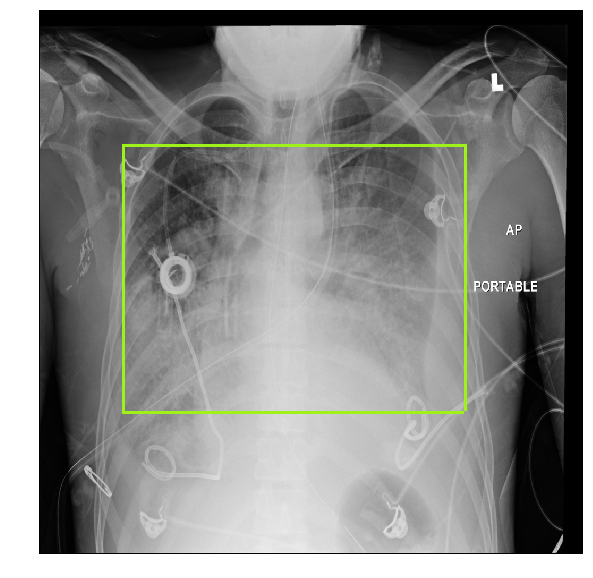

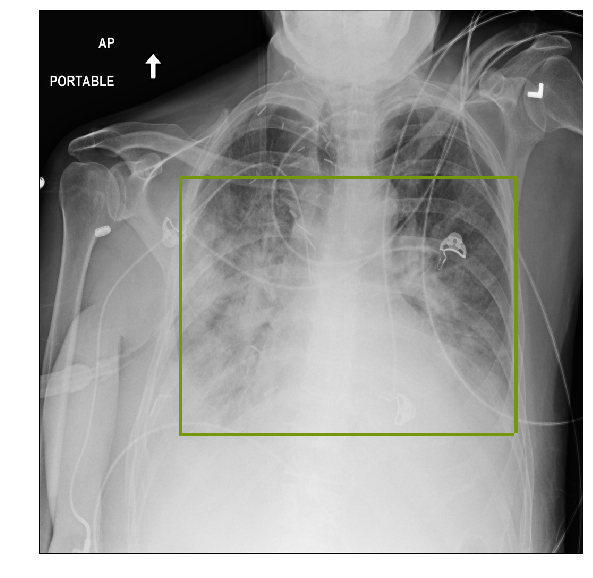

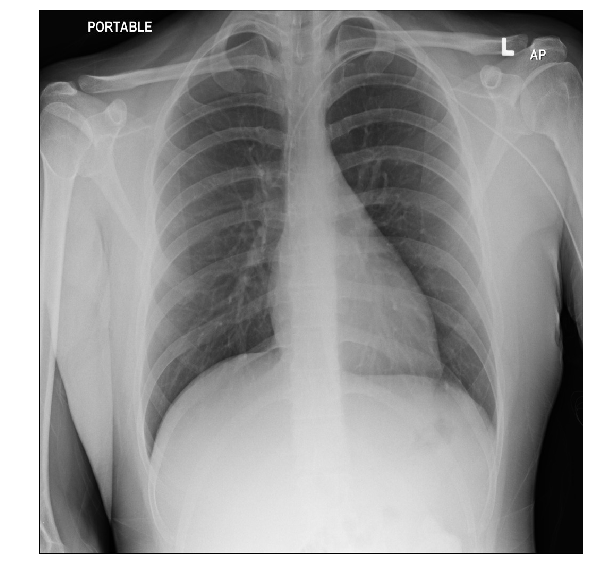

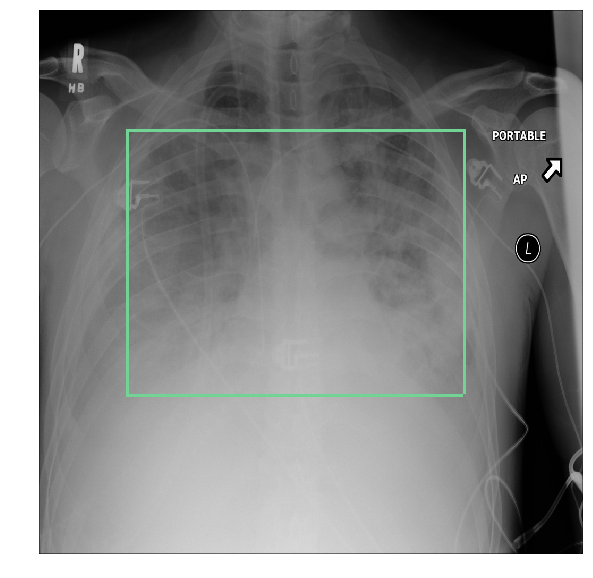

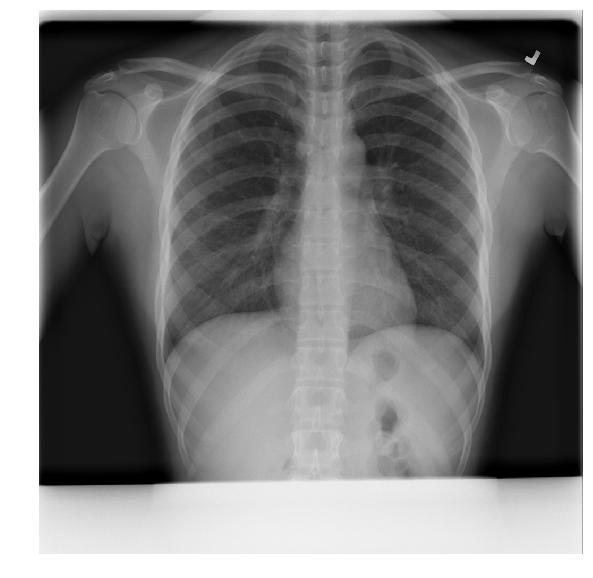

In [15]:
# Filenames of test images
test_dicom_paths = ut.get_image_paths(TEST_IMAGES)

for _ in range(5):
    test_results(random.choice(test_dicom_paths))

### Detect remaining test images ###

Detect the remaining test images and write the outcome to a CSV file.

In [18]:
ut.detect(model, test_dicom_paths, inference_config)

  0%|          | 0/1000 [00:00<?, ?it/s]

Detecting pnuemonia in test dataset...


100%|██████████| 1000/1000 [14:11<00:00,  1.17it/s]

Detections have been writen to detections.csv


# Analysis #

Running the next two cells on specific images, we can see that the model attempts to detect multiple instances of lung opacity. In the first case, it identifies separate cases of lung opacity and in the second case, one detection is a subset of the second bounding box. It is possible, with longer training, the model will correctly separate more cases of multiple lung opacity detections.

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  248.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  144.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.08847  max:    1.02591  float32


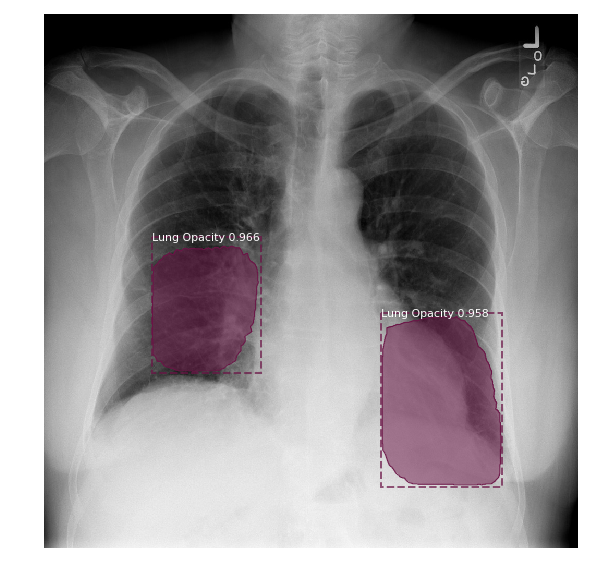

Patient ID: c059ced8-e99a-4fff-a734-b01cae2491bb
Confidence Score: [0.9658414  0.95820886]
Class ID: [1 1]


In [39]:
test_results(TEST_IMAGES + '/c059ced8-e99a-4fff-a734-b01cae2491bb.dcm')

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  242.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  138.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.08847  max:    1.02591  float32


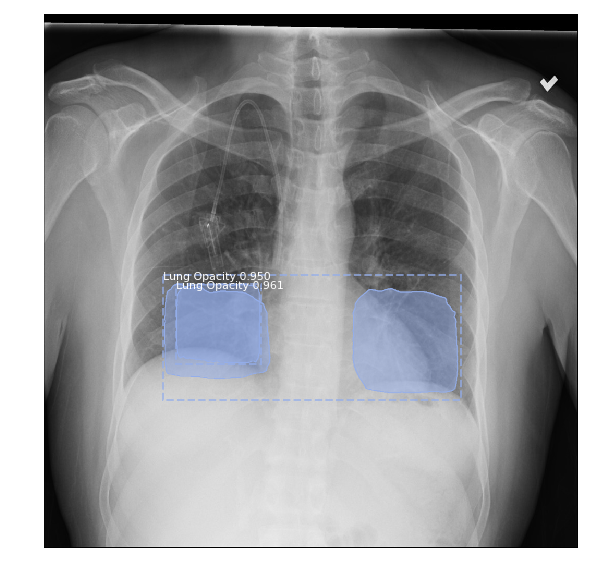

Patient ID: 029a7647-5a1b-45fd-bae0-35e4fa49f785
Confidence Score: [0.96122295 0.95033973]
Class ID: [1 1]


In [40]:
test_results(TEST_IMAGES + '/029a7647-5a1b-45fd-bae0-35e4fa49f785.dcm')